In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---
### Sub：Metrics

In [2]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def calcError(origin, forecast):
    print("RMSE", RMSE(origin, forecast))
    print("MAPE", MAPE(origin, forecast))

In [3]:
def showPlot(true, prediction, model , test_set, size='M', save=False):
    if(size=='L'):
        plt.figure(figsize=(28, 10))
    plt.plot(true, color = 'red', label = 'Real')
    plt.plot(prediction, color = 'blue', label = 'Prediction')
    plt.title('Industry Elec Prediction' + model + ' ' + test_set + ' t' + str(t))
    plt.xlabel('Time')
    plt.ylabel('kW')
    plt.legend()
    if(save):
        plt.savefig('Image/' + model + '-' + test_set + '-' + str(t) + '.jpeg')
    plt.show()


---
### Sub：Data

In [4]:
# 20160101~20161231 [0~366]
# 20170101~20171231 [366~731]
# 20180101~20181231 [731~1095]
# 20190101~20190930 [1096~1368]
# df = pd.read_csv('Data/elec_merge_20160101_20190930.csv')
df = pd.read_csv('Data/industryElec_processed_20170101_20190930.csv')
df.shape

(1003, 12)

In [5]:
df.head()

,日期,尖峰負載(MW),工業用電(百萬度),isHoliday,week,week_update,dayOfYear,Temp_Taipei,Temp_Taipei_shift,isHoliday_shift,尖峰負載(MW)_shift,weekUpdate_shift
0,2017-01-01,22886,268.503,1.0,7,7,1,17.5,15.8,1.0,24133.0,7.0
1,2017-01-02,24483,280.534,1.0,1,7,2,17.1,11.9,0.0,27670.0,1.0
2,2017-01-03,28131,320.449,0.0,2,1,3,16.6,13.1,0.0,27787.0,2.0
3,2017-01-04,28485,329.623,0.0,3,3,4,18.5,14.2,0.0,27992.0,3.0
4,2017-01-05,28336,330.137,0.0,4,4,5,18.0,15.5,0.0,28186.0,4.0


In [6]:
# features = ["工業用電(百萬度)", "民生用電(百萬度)",
#             "isHoliday", "isHoliday(Next7)",
#             "尖峰負載(MW)", "淨尖峰供電能力(MW)", 
#             "備轉容量(MW)", "備轉容量率(%)"]
features = ["工業用電(百萬度)",
            "isHoliday", "isHoliday_shift",
            "Temp_Taipei_shift",
            "Temp_Taipei"]
#             "尖峰負載(MW)"]

oneHot_features = ["week"]

oneHotActivate = False


In [7]:
def augFeatures(data, features_select=features):
    # 訓練資料擷取
    data = pd.DataFrame(data[features_select])
    data.shape
    return data

In [8]:
from sklearn.preprocessing import MinMaxScaler
def normalize(train):
    # Feature Scaling
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(train)
    return sc, training_set_scaled 

In [9]:
# Use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
def oneHot(train, oneHot_features=oneHot_features):
    if(oneHotActivate):
        oneHot_set = pd.DataFrame(train[oneHot_features])
        train=train.drop(columns=oneHot_features)
        # Build encoder
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit_transform(oneHot_set)
        train_onehot = enc.transform(oneHot_set).toarray()
        train_onehot = pd.DataFrame(train_onehot)

        train = pd.concat([train.reset_index(), train_onehot.reset_index()], axis = 1)
        train=train.drop(columns=["index"])
    return train

In [10]:
def buildTrain(train, pastDay=7, futureDay=7):
    X_train, Y_train = [], []
    for i in range(pastDay, len(train)-futureDay):
        X_train.append(train[i-pastDay:i])
        Y_train.append(train[i:i+futureDay, 0])

    # 轉成numpy array的格式，以利輸入 RNN    
    X_train, Y_train = np.array(X_train), np.array(Y_train)  

    # Reshape
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    print('X_train.shape', X_train.shape)
    print('Y_train.shape', Y_train.shape)
    return X_train, Y_train

In [11]:
def buildTest(startDate, sc, pastDay, futureDay, pre_step):
    dataset_total = df[(startDate-pastDay):(startDate-pastDay)+(pre_step*pastDay)]
    dataset_total = augFeatures(dataset_total)
    
    inputs = dataset_total
#     inputs = inputs.reshape(-1, dataset_total.shape[1])
    
    # OneHot
    inputs = oneHot(inputs)

    # Feature Scaling
    inputs = sc.transform(inputs)
    
    X_test = []
    for i in range(0, pre_step):
        X_test.append(inputs[pastDay*i:pastDay*(i+1)])
    X_test = np.array(X_test)

    # Reshape
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))  
    print('X_test.shape', X_test.shape)
    return X_test

In [12]:
def shuffle(X, Y):
#     np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

In [13]:
def splitData(X, Y, rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

---
### Sub：Model

In [14]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Flatten
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import CuDNNLSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import BatchNormalization, Bidirectional
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [15]:
def buildModel(shape, dropout_rate=0.1):
    # Initialising the LSTM
    model = Sequential()
    # Adding the first LSTM layer and some Dropout regularisation
    model.add(CuDNNLSTM(units = 256, return_sequences = True, input_shape = (shape[1], shape[2])))
    model.add(Dropout(dropout_rate))
#     model.add(CuDNNLSTM(units = 128, return_sequences = True))
#     model.add(Dropout(dropout_rate))
    model.add(Flatten())
    # Adding the output layer
    model.add(Dense(units = 7))
    
    model.summary()
    return model

---
### Main

In [16]:
# 載入時間包、計時開始
import time
tStart = time.time()

In [17]:
# 資料選取
# RawTrain = df[366:1096]
# RawTest = df[1096:]
RawTrain = df[0:730]
RawTest = df[730:]

# 特徵選取
training_set = augFeatures(RawTrain)

# OneHot
training_set_oneHot = oneHot(training_set)

# 資料前處理
sc, training_set_scaled = normalize(training_set_oneHot)

# 自定義變數
Timesteps = 7
OutputDay = 7

# 資料打包
X_train, Y_train = buildTrain(training_set_scaled, Timesteps, OutputDay)

# 資料亂序
# X_train, Y_train = shuffle(X_train, Y_train)

# 驗證資料
# X, Y, Xv, Yv= splitData(X_train, Y_train, 0.1)

X_train.shape (716, 7, 5)
Y_train.shape (716, 7)


In [18]:
model = buildModel(X_train.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 7, 256)            269312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 256)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1792)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 12551     
Total params: 281,863
Trainable params: 281,863
Non-trainable params: 0
_________________________________________________________________


In [19]:
from keras import optimizers
# initialize optimizer
# optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=0.0001), metrics=['mape'])
# Model.compile(loss='mean_squared_error', optimizer=RMSprop())
optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')
# model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])

In [20]:
# callback reduce_lr
from keras.callbacks import ReduceLROnPlateau
cb_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=15, mode='auto', verbose=1)
# callback cb_EarlyStop
cb_EarlyStop = EarlyStopping(monitor="val_loss", patience=20, verbose=1, mode="auto")

In [21]:
batch_size = 16
epochs = 200

history = model.fit(X_train, Y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose=1, 
                    shuffle=False,
#                     callbacks=[cb_reduce_lr],
                    callbacks=[cb_reduce_lr, cb_EarlyStop],
                    validation_split=0.1)

Train on 644 samples, validate on 72 samples
Epoch 1/200
644/644 [==============================] - 4s 6ms/step - loss: 0.0452 - val_loss: 0.0085
Epoch 2/200
644/644 [==============================] - 0s 370us/step - loss: 0.0253 - val_loss: 0.0175
Epoch 3/200
644/644 [==============================] - 0s 360us/step - loss: 0.0251 - val_loss: 0.0182
Epoch 4/200
644/644 [==============================] - 0s 384us/step - loss: 0.0159 - val_loss: 0.0106
Epoch 5/200
644/644 [==============================] - 0s 346us/step - loss: 0.0112 - val_loss: 0.0068
Epoch 6/200
644/644 [==============================] - 0s 360us/step - loss: 0.0094 - val_loss: 0.0043
Epoch 7/200
644/644 [==============================] - 0s 360us/step - loss: 0.0101 - val_loss: 0.0064
Epoch 8/200
644/644 [==============================] - 0s 370us/step - loss: 0.0112 - val_loss: 0.0069
Epoch 9/200
644/644 [==============================] - 0s 336us/step - loss: 0.0094 - val_loss: 0.0050
Epoch 10/200
644/644 [========

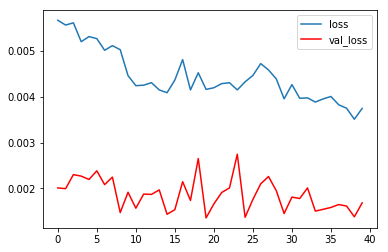

In [22]:
plt.plot(history.history['loss'][25:], label = 'loss')
plt.plot(history.history['val_loss'][25:], color = 'red', label = 'val_loss')
plt.legend()
plt.show()

---
## Time

In [23]:
t = 8
save = True
# save = False
model_name = '(LSTM_2017_F6_temp)'

---
## Load Model

In [24]:
# # load
# from keras.models import load_model
# model = load_model('Model/industryElec_cLSTM(7to7)_model_0' + str(t) + '.h5')

---
## Self-Prediction

In [25]:
# true
# self_true = pd.DataFrame(training_set[["工業用電(百萬度)"]])[0:1092].values[Timesteps:,]
self_true = pd.DataFrame(training_set[["工業用電(百萬度)"]])[0:721].values[Timesteps:,]
# self_train = buildTest(0+7, sc, Timesteps, OutputDay, int(len(self_true)/7))
self_train = buildTest(7, sc, Timesteps, OutputDay, int(len(self_true)/7))

X_test.shape (102, 7, 5)


In [26]:
# predict
self_predict = model.predict(self_train)
self_predict = self_predict * (sc.data_max_[0]-sc.data_min_[0]) + sc.data_min_[0]
self_prediction = []
# Type A
for i in range(int(len(self_true)/7)):
    self_prediction= np.concatenate((self_prediction, self_predict[i]), axis=0)
# Type B
# for i in range(len(self_true)):
#     self_prediction=np.append(self_prediction, np.array(self_predict[i][0]))

# Reshape
self_prediction = np.reshape(self_prediction, (self_true.shape[0], self_true.shape[1]))
print('self_true.shape', self_true.shape)
print('self_prediction.shape', self_prediction.shape)

self_true.shape (714, 1)
self_prediction.shape (714, 1)


RMSE 10.273688364901233
MAPE 2.272722912468143


ValueError: Format 'jpeg' is not supported (supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz)

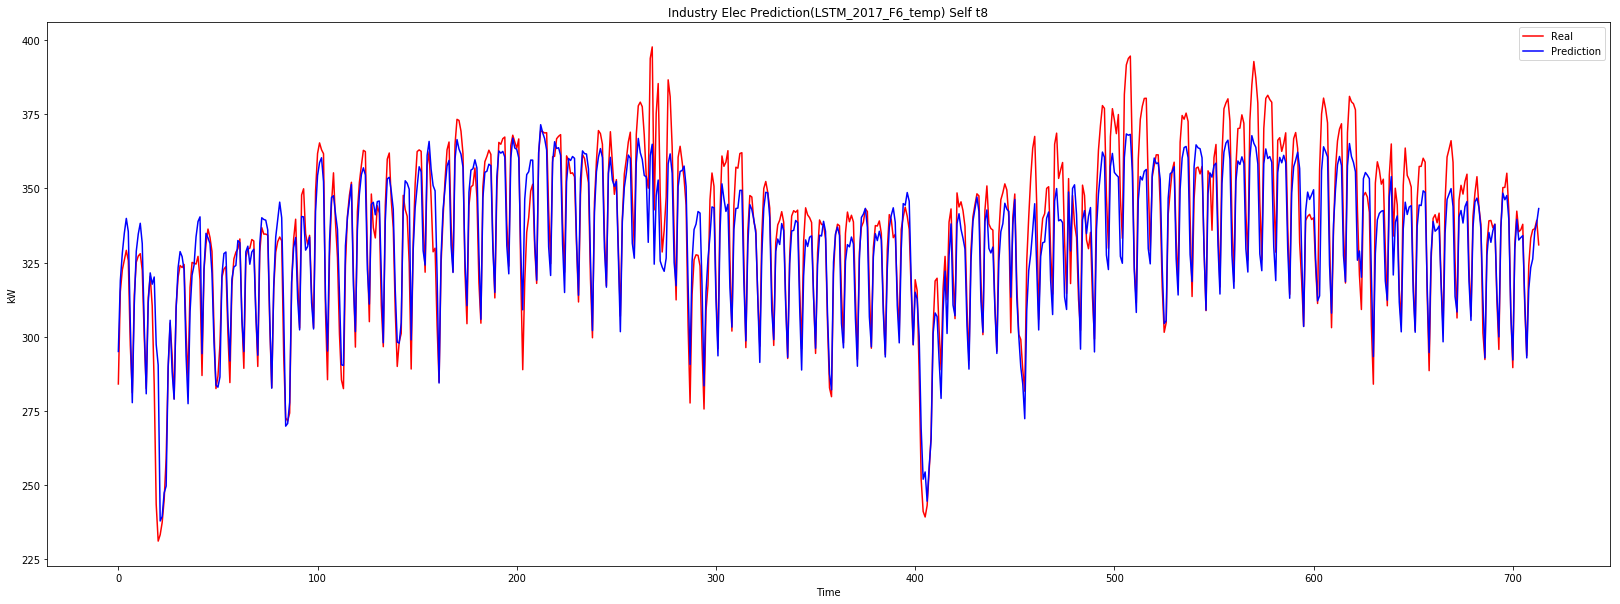

In [27]:
calcError(self_true, self_prediction)
showPlot(self_true, self_prediction, model_name, 'Self', 'L', save=save)

---
## Test-Prediction

In [ ]:
# 預測時長(1單位 = 7天)
# Pre_step = 1
# Pre_step = 4
Pre_step = 39

In [ ]:
# 真實值
pre_time = 7 * Pre_step
test_set = pd.DataFrame(RawTest[["工業用電(百萬度)"]])
test_set = test_set[:pre_time]
real_elec = test_set.values

# 訓練資料
X_test = buildTest(730, sc, Timesteps, OutputDay, Pre_step)

In [ ]:
test_predict = model.predict(X_test)
test_predict = test_predict * (sc.data_max_[0]-sc.data_min_[0]) + sc.data_min_[0]

# Append Data
test_prediction = []
for i in range(test_predict.shape[0]):
    test_prediction= np.concatenate((test_prediction, test_predict[i]), axis=0)
# Reshape
test_prediction = np.reshape(test_prediction, (real_elec.shape[0], real_elec.shape[1]))

# shape
print('real_elec.shape', real_elec.shape)
print('test_prediction.shape', test_prediction.shape)

In [ ]:
calcError(real_elec, test_prediction)
showPlot(real_elec, test_prediction, model_name , str(pre_time), save=save)

In [ ]:
#計時結束
tEnd = time.time()
print('Total time spent.....',tEnd - tStart, 'second')

---
## Save Model

In [ ]:
# import h5py
# Model.save('Model/industryElec_cLSTM(7to7)_model_01.h5')